In [1]:
import pyTigerGraph as tg
import numpy as np
import pandas as pd

conn = tg.TigerGraphConnection("http://3.22.188.182", graphname="KDD_2022_NFT", username="tigergraph", password="tigergraph")

conn.gds.configureKafka(kafka_address="kaf.kdd.tigergraphlabs.com:19092")

In [2]:
splitter = conn.gds.vertexSplitter(v_types=["Transaction"], train=0.8, test=0.2)

In [3]:
splitter.run()

Splitting vertices...
Vertex split finished successfully.


## Train on Category and Collection

In [4]:
train_loader = conn.gds.vertexLoader(
    attributes={"Transaction": ["usd_price", "categoryOneHot", "collectionOneHot"]},
    filter_by="train",
    batch_size=2048,
    shuffle=True
)

In [5]:
import torch

nn = torch.nn.Sequential(
    torch.nn.Linear(1075, 1000),
    torch.nn.ReLU(),
    torch.nn.Linear(1000, 1000),
    torch.nn.ReLU(),
    torch.nn.Linear(1000, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 1)
)

from torch.optim import Adam

opt = Adam(nn.parameters(), lr=0.01)
loss = torch.nn.SmoothL1Loss()
mae = torch.nn.L1Loss()

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
def r2_loss(output, target):
    target_mean = torch.mean(target)
    ss_tot = torch.sum((target - target_mean) ** 2)
    ss_res = torch.sum((target - output) ** 2)
    r2 = 1 - ss_res / ss_tot
    return r2

In [7]:
import numpy as np
def clean_onehots(x, length):
    arr = np.fromstring(x, sep=" ", dtype=np.float32)
    if len(arr) > length:
        arr = arr[:length]
    elif len(arr) < length:
        arr = np.zeros(length)
    return arr

In [8]:
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('runs/no_graph_feats_training'+str(datetime.now()))

/opt/conda/lib/python3.8/site-packages/torch/utils/tensorboard/__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, '__version__') or LooseVersion(tensorboard.__version__) < LooseVersion('1.15'):


In [9]:
for i in range(20):
    epoch_loss = 0
    epoch_mae = 0
    epoch_r2 = 0
    j = 0
    for batch in train_loader:
        catOH = torch.tensor(np.stack(batch["Transaction"]["categoryOneHot"].apply(lambda x: clean_onehots(x, 6)).values).astype(np.float32))
        collOH = torch.tensor(np.stack(batch["Transaction"]["collectionOneHot"].apply(lambda x: clean_onehots(x, 1069)).values).astype(np.float32))
        X = torch.tensor(np.concatenate([catOH, collOH], axis=1))
        y = torch.tensor(batch["Transaction"]["usd_price"].values.astype(np.float32))
        out = nn(X).flatten()
        loss_val = loss(out, y)
        opt.zero_grad()
        loss_val.backward()
        opt.step()
        mae_val = mae(out, y).item()
        r2_val = r2_loss(out, y).item()
        epoch_loss += loss_val.item()
        epoch_mae += mae_val
        epoch_r2 += r2_val
        
        writer.add_scalar('training loss',
                        loss_val.item(),
                        i * train_loader.num_batches + j)
        writer.add_scalar('training mae',
                          mae_val,
                          i * train_loader.num_batches + j)
        writer.add_scalar('training R2',
                          r2_val,
                          i * train_loader.num_batches + j)
        j += 1
    print("Epoch:", i, "Loss:", epoch_loss/train_loader.num_batches, "MAE:", epoch_mae/train_loader.num_batches, "R2:", epoch_r2/train_loader.num_batches)

Epoch: 0 Loss: 120.32298374176025 MAE: 120.74785868326823 R2: -0.0013004342714945476
Epoch: 1 Loss: 114.25001621246338 MAE: 114.66420459747314 R2: 0.08266956855853398
Epoch: 2 Loss: 111.84416071573894 MAE: 112.2590970993042 R2: 0.10205525904893875
Epoch: 3 Loss: 110.17908430099487 MAE: 110.59825547536214 R2: 0.1429478774468104
Epoch: 4 Loss: 106.5510729153951 MAE: 106.9690507253011 R2: 0.24351313461860022
Epoch: 5 Loss: 105.72125832239787 MAE: 106.13968292872111 R2: 0.0672108456492424
Epoch: 6 Loss: 105.33013439178467 MAE: 105.74596468607585 R2: -0.05249826113382975
Epoch: 7 Loss: 104.74563773473103 MAE: 105.16321134567261 R2: 0.09138783315817516
Epoch: 8 Loss: 104.2586654027303 MAE: 104.68125995000203 R2: 0.22021343310674033
Epoch: 9 Loss: 104.96220064163208 MAE: 105.38478994369507 R2: 0.06813962509234746
Epoch: 10 Loss: 103.92673794428508 MAE: 104.3408974011739 R2: -0.03646252055962881
Epoch: 11 Loss: 104.25726493199666 MAE: 104.67679977416992 R2: 0.18024841944376627
Epoch: 12 Loss: 

In [10]:
test_loader = conn.gds.vertexLoader(
    attributes={"Transaction": ["usd_price", "categoryOneHot", "collectionOneHot"]},
    filter_by="test",
    batch_size=2048
)

In [11]:
mae_sum = 0
r2_sum = 0
for batch in test_loader:
    catOH = torch.tensor(np.stack(batch["Transaction"]["categoryOneHot"].apply(lambda x: clean_onehots(x, 6)).values).astype(np.float32))
    collOH = torch.tensor(np.stack(batch["Transaction"]["collectionOneHot"].apply(lambda x: clean_onehots(x, 1069)).values).astype(np.float32))
    X = torch.tensor(np.concatenate([catOH, collOH], axis=1))
    y = torch.tensor(batch["Transaction"]["usd_price"].values.astype(np.float32))
    with torch.no_grad():
        out = nn(X).flatten()
        mae_sum += mae(out, y).item()
        r2_sum += r2_loss(out, y).item()
print("MAE:", mae_sum/test_loader.num_batches, "R2:", r2_sum/test_loader.num_batches)

MAE: 122.55917485555013 R2: -0.24367088079452515


## Add Graph Features

In [12]:
%%writefile ./seller_pagerank.gsql

CREATE QUERY seller_pagerank(BOOL print_accum = FALSE, STRING result_attr = "") {
    transactions = {Transaction.*};
    SumAccum<DOUBLE> @seller_pr;
    MaxAccum<DOUBLE> @@max_seller_pr;


    res = SELECT t FROM transactions:t -(NFT_SOLD_BY)-> NFT_User:u 
          ACCUM
            t.@seller_pr += u.pagerank,
            @@max_seller_pr += u.pagerank
          POST-ACCUM
            IF result_attr != "" THEN
                t.setAttr(result_attr, t.@seller_pr/@@max_seller_pr)
            END;
    IF print_accum THEN
      PRINT res[res.@seller_pr];
    END;
}

Overwriting ./seller_pagerank.gsql


In [13]:
featurizer = conn.gds.featurizer()

In [14]:
featurizer.installAlgorithm("seller_pagerank", query_path="./seller_pagerank.gsql")

'seller_pagerank'

In [15]:
params = {"result_attr": "seller_pr"}

try:
    featurizer.runAlgorithm("seller_pagerank", params, feat_name="seller_pr", feat_type="DOUBLE", custom_query=True, schema_name=["Transaction"])
except ConnectionError:
    featurizer.runAlgorithm("seller_pagerank", params)

In [16]:
%%writefile ./buyer_pagerank.gsql

CREATE QUERY buyer_pagerank(BOOL print_accum = FALSE, STRING result_attr = "") {
    transactions = {Transaction.*};
    SumAccum<DOUBLE> @buyer_pr;
    MaxAccum<DOUBLE> @@max_buyer_pr;


    res = SELECT t FROM transactions:t -(NFT_BOUGHT_BY)-> NFT_User:u 
          ACCUM
            t.@buyer_pr += u.pagerank,
            @@max_buyer_pr += u.pagerank
          POST-ACCUM
            IF result_attr != "" THEN
                t.setAttr(result_attr, t.@buyer_pr/@@max_buyer_pr)
            END;
    IF print_accum THEN
      PRINT res[res.@buyer_pr];
    END;
}

Overwriting ./buyer_pagerank.gsql


In [17]:
featurizer.installAlgorithm("buyer_pagerank", query_path="./buyer_pagerank.gsql")

'buyer_pagerank'

In [18]:
params = {"result_attr": "buyer_pr"}

try:
    featurizer.runAlgorithm("buyer_pagerank", params, feat_name="buyer_pr", feat_type="DOUBLE", custom_query=True, schema_name=["Transaction"])
except ConnectionError:
    featurizer.runAlgorithm("buyer_pagerank", params)

In [19]:
%%writefile ./kcore_size.gsql

CREATE QUERY kcore_size(BOOL print_accum = FALSE, STRING result_attr = "") FOR GRAPH KDD_2022_NFT { 
  MapAccum<INT, SumAccum<FLOAT>> @@kcore_size;
  MaxAccum<FLOAT> @@max_kcore_size;

  
  nftuser = {NFT_User.*};
  
  res = SELECT t FROM nftuser:t POST-ACCUM @@kcore_size += (t.k_core -> 1);
  
  IF print_accum THEN
    PRINT @@kcore_size;
  END;

  FOREACH (key, value) IN @@kcore_size DO
    @@max_kcore_size += value;
  END;
  
  IF result_attr != "" THEN
    res = SELECT t FROM nftuser:t POST-ACCUM t.setAttr(result_attr, @@kcore_size.get(t.k_core)/@@max_kcore_size);
  END;
}

Overwriting ./kcore_size.gsql


In [20]:
featurizer.installAlgorithm("kcore_size", query_path="./kcore_size.gsql")

'kcore_size'

In [21]:
params = {"result_attr": "kcore_size"}
try:
    featurizer.runAlgorithm("kcore_size", params, feat_name="kcore_size", feat_type="DOUBLE", custom_query=True, schema_name=["NFT_User"])
except ConnectionError:
    featurizer.runAlgorithm("kcore_size", params, custom_query=True)

In [22]:
%%writefile ./seller_kcore_size.gsql

CREATE QUERY seller_kcore_size(BOOL print_accum = FALSE, STRING result_attr = "") {
    transactions = {Transaction.*};
    SumAccum<DOUBLE> @seller_k_size;


    res = SELECT t FROM transactions:t -(NFT_SOLD_BY)-> NFT_User:u 
          ACCUM
            t.@seller_k_size += u.kcore_size
          POST-ACCUM
            IF result_attr != "" THEN
                t.setAttr(result_attr, t.@seller_k_size)
            END;
    IF print_accum THEN
      PRINT res[res.@seller_k_size];
    END;
}

Overwriting ./seller_kcore_size.gsql


In [23]:
featurizer.installAlgorithm("seller_kcore_size", query_path="./seller_kcore_size.gsql")

'seller_kcore_size'

In [24]:
params = {"result_attr": "seller_k_size"}

try:
    featurizer.runAlgorithm("seller_kcore_size", params, feat_name="seller_k_size", feat_type="DOUBLE", custom_query=True, schema_name=["Transaction"])
except ConnectionError:
    featurizer.runAlgorithm("seller_kcore_size", params)

In [25]:
%%writefile ./buyer_kcore_size.gsql

CREATE QUERY buyer_kcore_size(BOOL print_accum = FALSE, STRING result_attr = "") {
    transactions = {Transaction.*};
    SumAccum<DOUBLE> @buyer_k_size;


    res = SELECT t FROM transactions:t -(NFT_BOUGHT_BY)-> NFT_User:u 
          ACCUM
            t.@buyer_k_size += u.kcore_size
          POST-ACCUM
            IF result_attr != "" THEN
                t.setAttr(result_attr, t.@buyer_k_size)
            END;
    IF print_accum THEN
      PRINT res[res.@buyer_k_size];
    END;
}

Overwriting ./buyer_kcore_size.gsql


In [26]:
featurizer.installAlgorithm("buyer_kcore_size", query_path="./buyer_kcore_size.gsql")

'buyer_kcore_size'

In [27]:
params = {"result_attr": "buyer_k_size"}

try:
    featurizer.runAlgorithm("buyer_kcore_size", params, feat_name="buyer_k_size", feat_type="DOUBLE", custom_query=True, schema_name=["Transaction"])
except ConnectionError:
    featurizer.runAlgorithm("buyer_kcore_size", params)

In [28]:
tmp = conn.getSchema(force=True)

In [29]:
train_loader = conn.gds.vertexLoader(
    attributes={"Transaction": ["buyer_k_size", "seller_k_size", "usd_price", "seller_pr", "buyer_pr", "categoryOneHot", "collectionOneHot"]},
    filter_by="train",
    batch_size=2048,
    shuffle=True
)

In [30]:
import torch

nn = torch.nn.Sequential(
    torch.nn.Linear(1079, 1000),
    torch.nn.ReLU(),
    torch.nn.Linear(1000, 1000),
    torch.nn.ReLU(),
    torch.nn.Linear(1000, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 1)
)

from torch.optim import Adam

opt = Adam(nn.parameters(), lr=0.01)
loss = torch.nn.SmoothL1Loss()
mae = torch.nn.L1Loss()

In [31]:
writer = SummaryWriter('runs/graph_feats_training'+str(datetime.now()))

In [32]:
for i in range(20):
    epoch_loss = 0
    epoch_mae = 0
    epoch_r2 = 0
    j = 0
    for batch in train_loader:
        catOH = torch.tensor(np.stack(batch["Transaction"]["categoryOneHot"].apply(lambda x: clean_onehots(x, 6)).values).astype(np.float32))
        collOH = torch.tensor(np.stack(batch["Transaction"]["collectionOneHot"].apply(lambda x: clean_onehots(x, 1069)).values).astype(np.float32))
        X = torch.tensor(np.concatenate([batch["Transaction"][["seller_k_size", "buyer_k_size", "seller_pr", "buyer_pr"]].values.astype(np.float32), catOH, collOH], axis=1))
        y = torch.tensor(batch["Transaction"]["usd_price"].values.astype(np.float32))
        out = nn(X).flatten()
        loss_val = loss(out, y)
        opt.zero_grad()
        loss_val.backward()
        opt.step()
        mae_val = mae(out, y).item()
        r2_val = r2_loss(out, y).item()
        epoch_loss += loss_val.item()
        epoch_mae += mae_val
        epoch_r2 += r2_val
        writer.add_scalar('training loss',
                        loss_val.item(),
                        i * train_loader.num_batches + j)
        writer.add_scalar('training mae',
                          mae_val,
                          i * train_loader.num_batches + j)
        writer.add_scalar('training R2',
                          r2_val,
                          i * train_loader.num_batches + j)
        j += 1
    print("Epoch:", i, "Loss:", epoch_loss/train_loader.num_batches, "MAE:", epoch_mae/train_loader.num_batches, "R2:", epoch_r2/train_loader.num_batches)

Epoch: 0 Loss: 120.17808214823405 MAE: 120.6037761370341 R2: 0.0029494514067967734
Epoch: 1 Loss: 115.00749397277832 MAE: 115.42211453119914 R2: 0.046111720303694405
Epoch: 2 Loss: 112.05909633636475 MAE: 112.47952286402385 R2: 0.09785105288028717
Epoch: 3 Loss: 109.84701871871948 MAE: 110.26235357920329 R2: 0.14716691772143045
Epoch: 4 Loss: 105.68147087097168 MAE: 106.096182346344 R2: 0.2826652203996976
Epoch: 5 Loss: 106.62947305043538 MAE: 107.0497743288676 R2: 0.23791121194760004
Epoch: 6 Loss: 105.1743992169698 MAE: 105.58675813674927 R2: 0.21462049583594003
Epoch: 7 Loss: 104.54393784205119 MAE: 104.95377159118652 R2: 0.09813964863618214
Epoch: 8 Loss: 103.97302563985188 MAE: 104.3877838452657 R2: 0.17552023380994797
Epoch: 9 Loss: 104.86143223444621 MAE: 105.27289358774821 R2: 0.1290352319677671
Epoch: 10 Loss: 103.58221626281738 MAE: 103.99456850687663 R2: 0.17432577659686407
Epoch: 11 Loss: 103.46773703893025 MAE: 103.87672313054402 R2: 0.21363391975561777
Epoch: 12 Loss: 103

In [33]:
test_loader = conn.gds.vertexLoader(
    attributes={"Transaction": ["seller_k_size", "buyer_k_size", "usd_price", "seller_pr", "buyer_pr", "categoryOneHot", "collectionOneHot"]},
    filter_by="test",
    batch_size=2048
)

In [34]:
mae_sum = 0
r2_sum = 0
for batch in test_loader:
    catOH = torch.tensor(np.stack(batch["Transaction"]["categoryOneHot"].apply(lambda x: clean_onehots(x, 6)).values).astype(np.float32))
    collOH = torch.tensor(np.stack(batch["Transaction"]["collectionOneHot"].apply(lambda x: clean_onehots(x, 1069)).values).astype(np.float32))
    X = torch.tensor(np.concatenate([batch["Transaction"][["seller_k_size", "buyer_k_size", "seller_pr", "buyer_pr"]].values.astype(np.float32), catOH, collOH], axis=1))
    y = torch.tensor(batch["Transaction"]["usd_price"].values.astype(np.float32))
    with torch.no_grad():
        out = nn(X).flatten()
        mae_sum += mae(out, y).item()
        r2_sum += r2_loss(out, y).item()
print("MAE:", mae_sum/test_loader.num_batches, "R2:", r2_sum/test_loader.num_batches)

MAE: 122.86658604939778 R2: -0.15406687060991922


In [35]:
!pip install captum

In [36]:
from captum.attr import GradientShap

gs = GradientShap(nn)

/opt/conda/lib/python3.8/site-packages/captum/attr/_utils/visualization.py:15: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display


In [37]:
train_X = []


for train_batch in train_loader:
    catOH = torch.tensor(np.stack(train_batch["Transaction"]["categoryOneHot"].apply(lambda x: clean_onehots(x, 6)).values).astype(np.float32))
    collOH = torch.tensor(np.stack(train_batch["Transaction"]["collectionOneHot"].apply(lambda x: clean_onehots(x, 1069)).values).astype(np.float32))
    train_x = torch.tensor(np.concatenate([train_batch["Transaction"][["seller_k_size", "buyer_k_size", "seller_pr", "buyer_pr"]].values.astype(np.float32), catOH, collOH], axis=1))
    train_X.append(train_x)
train_X = torch.concat(train_X)

test_X = []
for test_batch in test_loader:
    catOH = torch.tensor(np.stack(test_batch["Transaction"]["categoryOneHot"].apply(lambda x: clean_onehots(x, 6)).values).astype(np.float32))
    collOH = torch.tensor(np.stack(test_batch["Transaction"]["collectionOneHot"].apply(lambda x: clean_onehots(x, 1069)).values).astype(np.float32))
    test_x = torch.tensor(np.concatenate([test_batch["Transaction"][["seller_k_size", "buyer_k_size", "seller_pr", "buyer_pr"]].values.astype(np.float32), catOH, collOH], axis=1))
    test_X.append(test_x)
test_X = torch.concat(test_X)

In [38]:
train_X.shape

torch.Size([47443, 1079])

In [39]:
test_X.shape

torch.Size([11891, 1079])

In [40]:
attribution = gs.attribute(test_X, train_X)

[Text(0, 0, 'Seller_k_size'),
 Text(1, 0, 'Buyer_k_size'),
 Text(2, 0, 'Seller_pr'),
 Text(3, 0, 'Buyer_pr')]

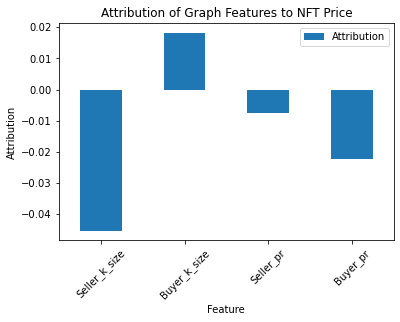

In [41]:
ig_nt_attr_test_sum = attribution.detach().numpy().sum(0)
ig_nt_attr_test_norm_sum = ig_nt_attr_test_sum / np.linalg.norm(ig_nt_attr_test_sum, ord=1)

attributions = pd.DataFrame({"Feature": ["Seller_k_size", "Buyer_k_size", "Seller_pr", "Buyer_pr"], "Attribution": ig_nt_attr_test_norm_sum[:4]})

plt = attributions.plot(kind="bar", xlabel="Feature", ylabel="Attribution", title="Attribution of Graph Features to NFT Price")
plt.set_xticklabels(attributions.Feature, rotation=45)